<h1> Exploring and creating ML datasets </h1>

In this notebook, we will explore data corresponding to taxi rides in New York City to build a Machine Learning model in support of a fare-estimation tool. The idea is to suggest a likely fare to taxi riders so that they are not surprised, and so that they can protest if the charge is much higher than expected.

Let's start off with the Python imports that we need.

In [1]:
import datalab.bigquery as bq
import seaborn as sns
import pandas as pd
import numpy as np
import shutil

<h3> Extract sample data from BigQuery </h3>

The dataset that we will use is <a href="https://bigquery.cloud.google.com/table/nyc-tlc:yellow.trips">a BigQuery public dataset</a>. Click on the link, and look at the column names. Switch to the Details tab to verify that the number of records is one billion, and then switch to the Preview tab to look at a few rows.

Let's write a SQL query to pick up interesting fields from the dataset.

In [2]:
%sql --module afewrecords
SELECT pickup_longitude, pickup_latitude, dropoff_longitude,
dropoff_latitude, passenger_count, trip_distance, tolls_amount, 
fare_amount, total_amount FROM [nyc-tlc:yellow.trips] LIMIT 10

In [3]:
trips = bq.Query(afewrecords).to_dataframe()
trips

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,tolls_amount,fare_amount,total_amount
0,0.000000,0.000000,0.000000,0.000000,1,0.00,0.0,0.0,0.0
1,-73.902177,40.764137,-73.902177,40.764137,1,0.00,0.0,0.0,0.0
2,-73.937290,40.758155,-73.937273,40.758190,1,0.00,0.0,0.0,0.0
3,-73.902052,40.763827,-73.902087,40.763877,5,0.00,0.0,0.0,0.0
4,0.000000,0.000000,0.000000,0.000000,6,1.01,0.0,0.0,0.0
5,-73.781865,40.644825,-73.780893,40.645107,2,0.09,0.0,2.5,2.5
6,-73.967515,40.756262,-73.950483,40.775313,1,2.10,0.0,2.5,2.5
7,-73.937423,40.758152,-73.937423,40.758152,1,0.00,0.0,2.5,2.5
8,-73.974767,40.764330,-73.974383,40.763957,1,0.03,0.0,2.5,2.5
9,-73.962618,40.772845,-73.962678,40.772763,1,0.00,0.0,2.5,2.5


Let's increase the number of records so that we can do some neat graphs.  There is no guarantee in what order records are returned, and so no guarantee about which records get returns if simply increase the LIMIT. To properly sample the dataset, let's use the HASH of the pickup time and return 1 in EVERY_N records where EVERY_N is parameter to the query.

In [4]:
%sql --module afewrecords2
SELECT
  pickup_longitude, pickup_latitude, 
  dropoff_longitude, dropoff_latitude,
  passenger_count,
  trip_distance,
  tolls_amount,
  fare_amount,
  total_amount
FROM
  [nyc-tlc:yellow.trips]
WHERE
  ABS(HASH(pickup_datetime)) % EVERY_N == 1

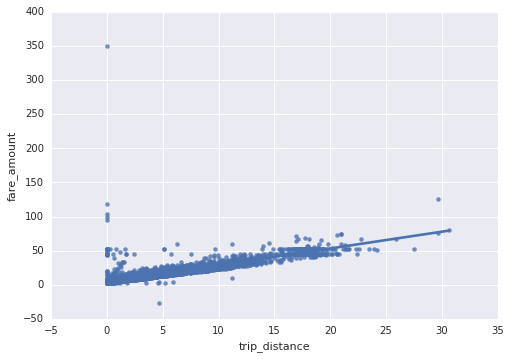

In [5]:
trips = bq.Query(afewrecords2, EVERY_N=100000).to_dataframe()
trips[:10]

<h3> Exploring data </h3>

Let's explore this dataset and clean it up as necessary. We'll use the Python Seaborn package to visualize graphs and Pandas to do the slicing and filtering.

In [ ]:
ax = sns.regplot(x="trip_distance", y="fare_amount", ci=None, truncate=True, data=trips)

Hmm ... can see something wrong with the data that needs addressing?

It appears that we have a lot of invalid data that is being coded as zero distance and some fare amounts that are definitely illegitimate. Let's remove them from our analysis. We can do this by modifying the BigQuery query to keep only trips longer than zero miles and fare amounts that are at least the minimum cab fare ($2.50).

Note the extra WHERE clauses.

In [6]:
%sql --module afewrecords3
SELECT
  pickup_longitude, pickup_latitude, 
  dropoff_longitude, dropoff_latitude,
  passenger_count,
  trip_distance,
  tolls_amount,
  fare_amount,
  total_amount
FROM
  [nyc-tlc:yellow.trips]
WHERE
  (ABS(HASH(pickup_datetime)) % EVERY_N == 1 AND
  trip_distance > 0 AND fare_amount >= 2.5)

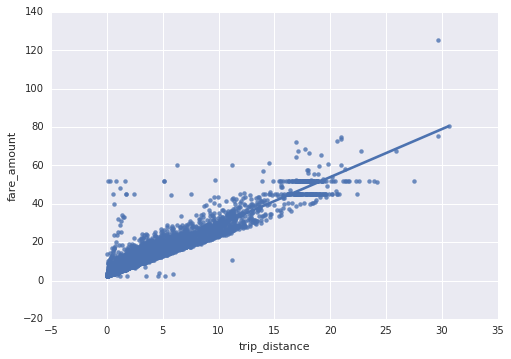

In [7]:
trips = bq.Query(afewrecords3, EVERY_N=100000).to_dataframe()
ax = sns.regplot(x="trip_distance", y="fare_amount", ci=None, truncate=True, data=trips)

What's up with the streaks at $45 and $50?  Those are fixed-amount rides from JFK and La Guardia airports into anywhere in Manhattan, i.e. to be expected. Let's list the data to make sure the values look reasonable

In [8]:
trips[:10]

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,tolls_amount,fare_amount,total_amount
0,-73.967463,40.760662,-73.964557,40.760352,1,1.07,0.0,5.5,7.1
1,-73.962795,40.778077,-73.970983,40.790178,1,1.41,0.0,8.5,9.0
2,-73.988248,40.737322,-73.972325,40.761027,5,1.93,0.0,8.5,10.0
3,-73.976255,40.764040,-74.002510,40.760737,2,1.94,0.0,11.0,11.5
4,-73.968707,40.801425,-73.970862,40.765753,5,3.29,0.0,12.5,15.0
5,-73.994615,40.755897,-73.985842,40.677822,1,6.18,0.0,21.0,21.5
6,-73.790223,40.647010,-73.982842,40.764692,1,18.41,4.8,45.0,53.3
7,-73.966462,40.761487,-73.956837,40.771508,2,0.96,0.0,4.1,5.1
8,-73.960598,40.772442,-73.956216,40.784264,1,0.80,0.0,4.9,4.9
9,-74.003358,40.727302,-73.983620,40.751402,1,2.16,0.0,7.7,7.7


In [9]:
trips.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,tolls_amount,fare_amount,total_amount
count,11400.000000,11400.000000,11400.000000,11400.000000,11400.000000,11400.000000,11400.000000,11400.00000,11400.000000
mean,-72.527656,39.618013,-72.404513,39.868820,1.724298,2.838210,0.225352,11.00331,13.051914
std,18.541663,28.118268,11.567656,7.355304,1.345698,3.268861,1.103000,8.66286,10.482479
min,-1687.399757,-2895.273900,-74.417107,-444.385228,0.000000,0.010000,0.000000,2.50000,2.500000
25%,-73.992114,40.735475,-73.991601,40.733683,1.000000,1.010000,0.000000,6.00000,7.100000
50%,-73.981698,40.753039,-73.980396,40.753262,1.000000,1.740000,0.000000,8.40000,9.880000
75%,-73.966769,40.767687,-73.964285,40.768254,2.000000,3.160000,0.000000,12.50000,14.500000
max,0.009137,41.366138,443.321210,41.366138,6.000000,30.600000,19.500000,125.55000,149.630000


Hmm ... The min, max of longitude look strange.

<h3> Quality control </h3>

New York city longitudes are around -72 and latitudes are around 40. We shouldn't have zero passengers either.  Let's prune such outliers.

In [18]:
def apply_qc(trips):
  qc = np.all([\
             trips['pickup_longitude'] > -75, \
             trips['pickup_longitude'] < -70, \
             trips['dropoff_longitude'] > -75, \
             trips['dropoff_longitude'] < -70, \
             trips['passenger_count'] > 0,
            ], axis=0)
  return trips[qc]

tripsqc = apply_qc(trips)
tripsqc.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,tolls_amount,fare_amount,total_amount
count,11103.000000,11103.000000,11103.000000,11103.000000,11103.000000,11103.000000,11103.000000,11103.000000,11103.000000
mean,-73.975294,40.747695,-73.974713,40.747739,1.731154,2.838621,0.225188,11.005890,13.051666
std,0.038607,0.387221,0.038457,0.381334,1.343884,3.271750,1.096951,8.655957,10.463500
min,-74.417107,0.070608,-74.417107,0.730002,1.000000,0.010000,0.000000,2.500000,2.500000
25%,-73.992340,40.737097,-73.991876,40.735402,1.000000,1.010000,0.000000,6.000000,7.100000
50%,-73.982062,40.753873,-73.980860,40.753990,1.000000,1.740000,0.000000,8.500000,9.880000
75%,-73.968300,40.768100,-73.966183,40.768612,2.000000,3.155000,0.000000,12.500000,14.500000
max,-73.137393,41.366138,-73.137393,41.366138,6.000000,30.600000,19.500000,125.550000,149.630000


The quality control has removed about 300 rows (11400 - 11103) or about 3% of the data. This seems reasonable.

<h3> Create ML datasets </h3>

Let's now split the data randomly into training, validation and test sets.

In [20]:
shuffled = tripsqc.sample(frac=1)
trainsize = int(len(shuffled['fare_amount']) * 0.70)
validsize = int(len(shuffled['fare_amount']) * 0.15)

df_train = shuffled.iloc[:trainsize, :]
df_valid = shuffled.iloc[trainsize:(trainsize+validsize), :]
df_test = shuffled.iloc[(trainsize+validsize):, :]

In [21]:
df_train.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,tolls_amount,fare_amount,total_amount
count,7772.000000,7772.000000,7772.000000,7772.000000,7772.000000,7772.000000,7772.000000,7772.000000,7772.000000
mean,-73.975389,40.746117,-73.974638,40.745988,1.726711,2.843298,0.235566,11.013047,13.079256
std,0.036583,0.462311,0.037247,0.455136,1.346606,3.292598,1.116927,8.736054,10.598840
min,-74.417107,0.070608,-74.417107,0.730002,1.000000,0.010000,0.000000,2.500000,2.500000
25%,-73.992320,40.737158,-73.991954,40.735969,1.000000,1.000000,0.000000,6.000000,7.100000
50%,-73.982057,40.754142,-73.980721,40.753933,1.000000,1.730000,0.000000,8.500000,9.800000
75%,-73.967962,40.768204,-73.965962,40.768385,2.000000,3.140000,0.000000,12.500000,14.500000
max,-73.137393,41.366138,-73.137393,41.366138,6.000000,30.600000,19.500000,125.550000,149.630000


In [22]:
df_valid.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,tolls_amount,fare_amount,total_amount
count,1665.000000,1665.000000,1665.000000,1665.000000,1665.000000,1665.000000,1665.000000,1665.000000,1665.000000
mean,-73.973915,40.751149,-73.974035,40.752254,1.742943,2.860529,0.212486,11.037598,13.019201
std,0.050994,0.038629,0.048660,0.040862,1.323325,3.282715,1.094752,8.579655,10.210608
min,-74.236488,40.514429,-74.243160,40.514429,1.000000,0.030000,0.000000,2.900000,2.900000
25%,-73.992594,40.736035,-73.991333,40.734750,1.000000,1.010000,0.000000,6.000000,7.100000
50%,-73.982294,40.752547,-73.981385,40.754455,1.000000,1.790000,0.000000,8.500000,10.000000
75%,-73.969677,40.767387,-73.966302,40.769365,2.000000,3.200000,0.000000,12.500000,14.300000
max,-73.137393,41.366138,-73.137393,41.366138,6.000000,23.500000,15.750000,68.500000,86.550000


In [23]:
df_test.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,tolls_amount,fare_amount,total_amount
count,1666.000000,1666.000000,1666.000000,1666.000000,1666.000000,1666.000000,1666.000000,1666.000000,1666.000000
mean,-73.976228,40.751602,-73.975745,40.751395,1.740096,2.794910,0.189466,10.940816,12.955402
std,0.033028,0.026570,0.031909,0.032793,1.352222,3.162938,1.000607,8.356000,10.075871
min,-74.038208,40.641163,-74.183834,40.582582,1.000000,0.050000,0.000000,2.500000,3.000000
25%,-73.992252,40.737785,-73.992202,40.734000,1.000000,1.050000,0.000000,6.100000,7.300000
50%,-73.981932,40.754145,-73.981321,40.754042,1.000000,1.790000,0.000000,8.100000,9.800000
75%,-73.968369,40.768152,-73.966985,40.769083,2.000000,3.127500,0.000000,12.500000,14.600000
max,-73.749060,40.891523,-73.741925,41.168578,6.000000,27.500000,13.150000,67.500000,97.950000


In [25]:
df_train.to_csv('taxi-train.csv', header=False, index_label=False, index=False)
df_valid.to_csv('taxi-valid.csv', header=False, index_label=False, index=False)
df_test.to_csv('taxi-test.csv', header=False, index_label=False, index=False)